In [1]:
import huxt as H
import huxt_analysis as HA
import SIR_HUXt as sir

import astropy.units as u
import glob
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as st

from sklearn.neighbors import KernelDensity
from astropy.time import Time

In [2]:
# Test the SIR scheme
np.random.seed(20100114)

start_time = Time('2008-06-30T00:00:00')

for i in range(50):
    
    model = sir.setup_huxt(start_time, uniform_wind=True)

    # Generate a "truth" CME
    base_cme = sir.get_base_cme()
    cme_truth = sir.perturb_cme(base_cme)

    # Get HUXt solution of this truth CME, and observations from L5
    model.solve([cme_truth])
    cme_truth = model.cmes[0]
    hit, t_arrive, t_transit, hit_lon, hit_id = cme_truth.compute_arrival_at_body('EARTH')
    
    observer_lon = -60*u.deg
    L5Obs = sir.Observer(model, cme_truth, observer_lon, el_min=4.0, el_max=30.0)

    model_flank = L5Obs.model_flank
    observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=4.0, el_max=30.0)
    
    observations = {'t_arrive':t_arrive, 't_transit':t_transit, 'observer_lon':observer_lon,
                    'observed_cme_flank':observed_cme_flank, 'cme_params':cme_truth.parameter_array()}
    
    tag = "uniform_weak_run_{:03d}".format(i)
    sir.SIR(model, base_cme, observations, tag)

Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files already exist for CR2071
Files al

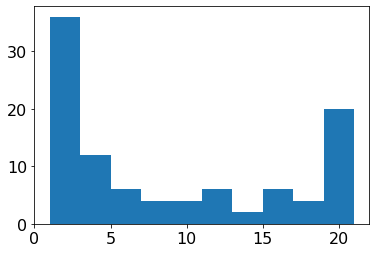

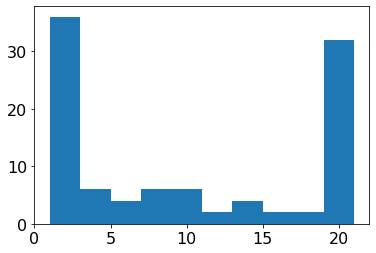

In [8]:
weak_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_weak_run*.hdf5")
standard_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_run*.hdf5")
strong_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_strong_run*.hdf5")

for files in [weak_files, standard_files, strong_files]:
    
    ess_all = []
    rank_hist_data = []
    for f in files:

        out_file = h5py.File(f, 'r')

        pdf_max = []
        ess = []
        for i in range(8):

            key = "analysis_{:02d}".format(i)
            v = out_file[key]['speeds'][:]

            kde = KernelDensity(kernel='gaussian', bandwidth=25).fit(v.reshape(-1,1))
            v_grid = np.arange(800,1200,1)
            log_pdf = kde.score_samples(v_grid.reshape(-1,1))
            pdf = np.exp(log_pdf)
            pdf_max.append(pdf.max())

            w = out_file[key]['weights'][:]
            ess.append(1 / np.sum(w**2))

            if i==7:
                cme_truth_params = out_file['cme_params'][:]
                v_truth = cme_truth_params[4]
                v_all = np.append(v,v_truth)
                v_ranks = st.rankdata(v_all)
                rank_hist_data.append(v_ranks[-1])


        cme_truth_params = out_file['cme_params'][:]
        v_truth = cme_truth_params[4]
        
        cme_truth_params = out_file['cme_params'][:]
        v_truth = cme_truth_params[4]
        v_all = np.append(v,v_truth)
        v_ranks = st.rankdata(v_all)
        rank_hist_data.append(v_ranks[-1])
        ess_all.append(ess[-1])

        out_file.close()
        
    fig, ax = plt.subplots()
    ax.hist(rank_hist_data)
